# Flight Delay Predictor
### This Python script loads flight data, cleans it, and performs exploratory data analysis (EDA) to understand the correlation between various factors and flight delays. It then preprocesses the data, including one-hot encoding categorical variables and standardizing numerical variables. Several machine learning models are trained and evaluated to predict flight delays accurately. Finally, the best-performing model is used to make predictions for future flight delays at a specific airport.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the data from the CSV file
df = pd.read_csv('cleaned_adw_df_1.csv')
cols_to_remove = ['Delay National Aviation System (Minutes)_a', 'Delay Security (Minutes)_a', 'Delay Late Aircraft Arrival (Minutes)_a', 
                  'Delay National Aviation System (Minutes)_d', 'Delay Security (Minutes)_d', 'Delay Late Aircraft Arrival (Minutes)_d']
df = df.drop(columns=cols_to_remove)

# filtered data based on year
years_to_filter = {2019,2020,2021,2022,2023}
df = df[df['Year'].isin(years_to_filter)]

airport = 'JFK'

df = df[df['Origin Airport_a']==airport]

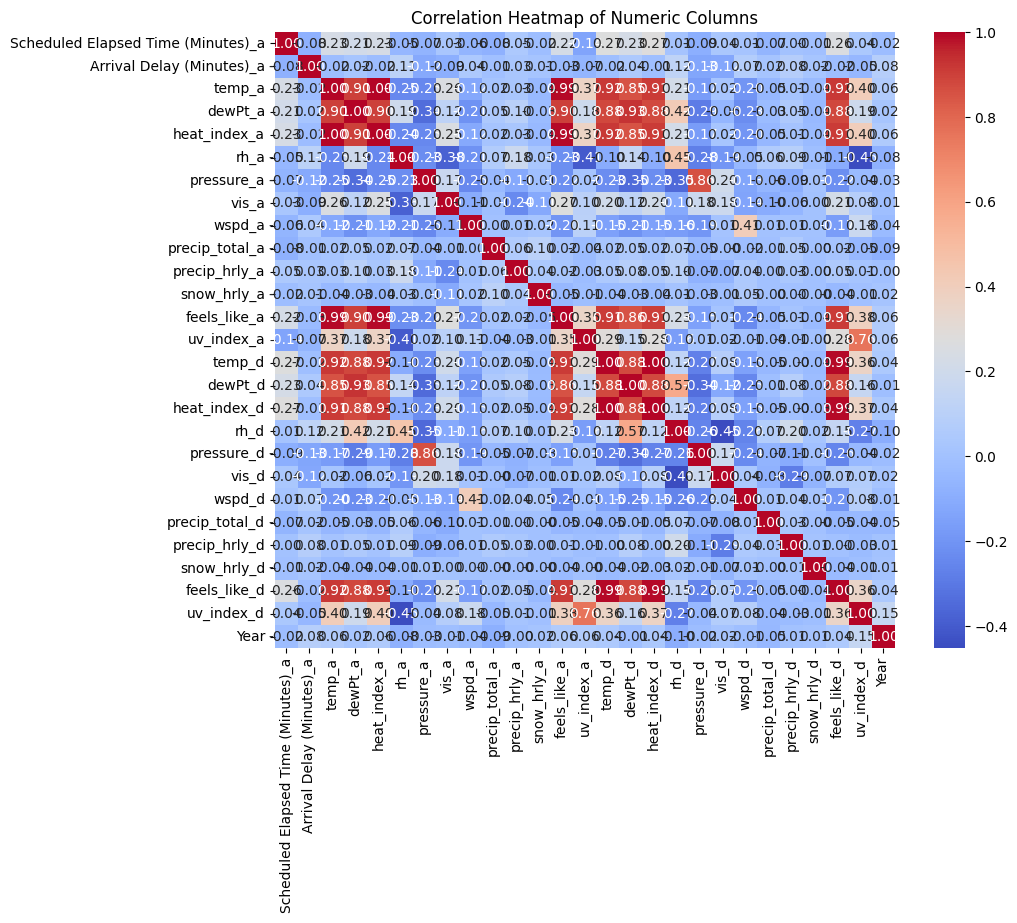

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
# corr_matrix = df.corr(numeric_only=True)
# sns.heatmap(corr_matrix, cmap='coolwarm')

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [3]:
# Convert categorical variables to numerical using one-hot encoding
categorical_cols = ['Origin Airport_a', 'wx_phrase_a', 'uv_desc_a', 'clds_a',
                    'wx_phrase_d', 'uv_desc_d', 'clds_d', 'Main_Carrier', 'Week_Category', 'A_Time_of_Day']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Calculate correlation with "Arrival Delay (Minutes)_a" and sort by absolute value
corr_with_delay = df.corr()['Arrival Delay (Minutes)_a'].abs().sort_values(ascending=False)

# print(corr_with_delay)

# Select top 12 features with low intercorrelation
selected_features = []
for feature in corr_with_delay.index:
    if len(selected_features) >= 25:
        break
    if corr_with_delay[feature] >= -0.1:
        selected_features.append(feature)
        
selected_features.remove('Arrival Delay (Minutes)_a')
print(selected_features)

# Print remaining numerical columns
remaining_numeric_cols = [col for col in numeric_cols.columns if col not in selected_features]
remaining_numeric_cols.remove('Arrival Delay (Minutes)_a')
print("Remaining Numerical Columns:")
print(remaining_numeric_cols)

# Remove the specified columns

columns_to_remove = remaining_numeric_cols
# .append('Year')

df = df.drop(columns=remaining_numeric_cols)

['Main_Carrier_B6', 'pressure_d', 'Main_Carrier_DL', 'vis_d', 'rh_d', 'pressure_a', 'rh_a', 'A_Time_of_Day_Night', 'vis_a', 'clds_d_OVC', 'wx_phrase_d_Snowy', 'Year', 'Scheduled Elapsed Time (Minutes)_a', 'precip_hrly_d', 'wx_phrase_d_Rainy', 'wspd_d', 'uv_index_a', 'wx_phrase_a_Snowy', 'uv_desc_d_Moderate', 'A_Time_of_Day_Morning Peak', 'uv_index_d', 'clds_a_FEW', 'uv_desc_a_Low', 'uv_desc_d_Low']
Remaining Numerical Columns:
['temp_a', 'dewPt_a', 'heat_index_a', 'wspd_a', 'precip_total_a', 'precip_hrly_a', 'snow_hrly_a', 'feels_like_a', 'temp_d', 'dewPt_d', 'heat_index_d', 'precip_total_d', 'snow_hrly_d', 'feels_like_d']


In [4]:
df.head(2)

Scheduled Elapsed Time (Minutes)_a  Arrival Delay (Minutes)_a  rh_a  \
1                                70.0                      -12.0  82.0   
2                                82.0                        2.0  76.0   

   pressure_a  vis_a  uv_index_a   rh_d  pressure_d  vis_d  wspd_d  ...  \
1       29.29   10.0         0.0  100.0       29.63   10.0    12.0  ...   
2       29.52   10.0         0.0   75.0       29.73   10.0    23.0  ...   

   clds_d_SCT  Main_Carrier_B6  Main_Carrier_DL  Week_Category_StartOfWeek  \
1       False             True            False                      False   
2       False            False             True                      False   

   Week_Category_Weekend  A_Time_of_Day_Evening  A_Time_of_Day_Evening Peak  \
1                  False                  False                       False   
2                  False                  False                       False   

   A_Time_of_Day_Morning  A_Time_of_Day_Morning Peak  A_Time_of_Day_Night  
1                   True                       False                False  
2                  False                        True                False  

[2 rows x 46 columns]

In [5]:
def calculate_summary_statistics(df, columns):
    # Separate numerical and categorical columns based on the input list
    numerical_cols = [col for col in columns if df[col].dtype in ['int64', 'float64']]
    categorical_cols = [col for col in columns if df[col].dtype in ['object', 'category']]
    boolean_cols = [col for col in columns if df[col].dtype == 'bool']

    # Calculate average for numerical columns
    numerical_avg = df[numerical_cols].mean()

    # # Calculate mode for categorical columns
    # categorical_mode = df[categorical_cols].mode().iloc[0]

    # Print the summary statistics
    print("Average for Numerical Columns:")
    print(numerical_avg)
    # print("\nMode for Categorical Columns:")
    # print(categorical_mode)
        # Calculate proportion of True values for boolean columns
    for col in boolean_cols:
        true_prop = df[col].mean()  # True proportion is the mean (since True=1, False=0)
    print(f"\nProportion of True values in column '{col}': {true_prop:.2%}")

calculate_summary_statistics(df, selected_features)

Average for Numerical Columns:
pressure_d                              30.030215
vis_d                                    9.296290
rh_d                                    67.683439
pressure_a                              29.567523
rh_a                                    66.380780
vis_a                                    9.257233
Year                                  2021.040647
Scheduled Elapsed Time (Minutes)_a      81.913871
precip_hrly_d                            0.004926
wspd_d                                  11.984739
uv_index_a                               0.719704
uv_index_d                               0.835600
dtype: float64

Proportion of True values in column 'uv_desc_d_Low': 88.64%


In [6]:
# Define the target variable based on arrival delay
df['Class of Arrival Time'] = pd.cut(df['Arrival Delay (Minutes)_a'],
                                       bins=[float('-inf'), -5, 5, float('inf')],
                                       labels=['Early', 'On-time', 'Late'])

# Drop unnecessary columns and the target variable
X = df.drop(['Arrival Delay (Minutes)_a', 'Class of Arrival Time'], axis=1)
y = df['Class of Arrival Time']
# y = df['Arrival Delay (Minutes)_a']

X_encoded = X
# Standardize numerical columns
numerical_cols = selected_features
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,stratify = y,test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Identify the model with the highest accuracy
best_model_name = None
best_accuracy = 0

# Initialize and train different models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42,n_estimators = 250,max_depth = 50, learning_rate= 1 ),
    'ada' : AdaBoostClassifier(random_state=42),
# 'xg':  XGBClassifier(random_state=42),
'knn' : KNeighborsClassifier(n_neighbors=15),
'dtree':  DecisionTreeClassifier(max_depth=7,random_state=42),
'rand_class':  RandomForestClassifier(max_depth=15,random_state=42),
'GNB':  GaussianNB()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
    # mae = mean_absolute_error(y_test, y_pred)
    # mae_ratio = mae / np.mean(y_test)
    # print("MAE:", mae)
    # print("MAE Ratio:", mae_ratio)
    # print(model.score(X_test,y_test))
    # print(classification_report(y_test, y_pred))
    # print('-' * 50)

# Select the best model
best_model = models[best_model_name]

print("model with most accuracy is " + str(best_model))

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.63
Decision Tree Accuracy: 0.51
Random Forest Accuracy: 0.63
SVM Accuracy: 0.63
Gradient Boosting Accuracy: 0.54
ada Accuracy: 0.63
knn Accuracy: 0.62
dtree Accuracy: 0.59
rand_class Accuracy: 0.63
GNB Accuracy: 0.57
model with most accuracy is SVC(random_state=42)


In [8]:

# Load the data from the CSV file
df = pd.read_csv('CIS_662_FINAL_Predictions.csv')

# Filter rows with ORIGIN as airport
airport_data_index = df[df['Origin Airport_a'] == airport].index

# Perform one-hot encoding on the specfic aiport data using previous encoder
airport_data_encoded = pd.get_dummies(df.loc[airport_data_index], columns=categorical_cols, drop_first=True)

# Standardize numerical columns using previous scaler
airport_data_encoded[numerical_cols] = scaler.transform(airport_data_encoded[numerical_cols])

# Drop any columns not used in the training data
airport_data_encoded = airport_data_encoded[X_train.columns]

# Make predictions using the selected model
predictions = best_model.predict(airport_data_encoded)

# Create a new column 'y' in the specific airport data subset and store the predictions in it
df.loc[airport_data_index, 'ARRIVAL TIME'] = predictions

# Save the updated DataFrame back to the same file
df.to_csv('CIS_662_FINAL_Predictions.csv', index=False)

print(airport + " airport prediction for ARRIVAL STATUS are created")


JFK airport prediction for ARRIVAL STATUS are created
